In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Part 4

In [2]:
df = pd.read_csv('DataPart4.csv')
df

,Phi,Ti,Te,W
0,1496.970334,20.002530,12.255610,8.678768
1,1411.792178,19.957051,12.298405,7.185271
2,1368.595696,19.904727,12.576470,6.684292
3,1404.547674,19.886161,12.455047,7.702868
4,1376.436161,19.908530,12.638600,7.047383
...,...,...,...,...
523,1562.245721,18.266840,7.891040,1.971089
524,1598.095613,18.528092,8.104441,2.247106
525,1651.313837,18.918916,7.897160,1.942645
526,1635.842866,18.702865,7.991617,2.043882


During the heating season, the heat-loss coefficient of buildings, $U_a$, is often estimated under the assumption that the internal temperature is kept constant, so that the heat load is described by

$\Phi_t = U_a(T_t^i - T_t^e) + \epsilon_t$,

where $\Phi_t$ is heat load, $U_a$ is the heat loss coefficient and $T_t^i$ and $T_t^e$ are the internal and external temperatures. The problem with this approach is that the heat loss coefficient depends nonlinearly on the wind speed. Using the data from DataPart4.csv, but with $U_a$ as a non-parametric function of the wind speed, i.e

$\Phi_t = U_a(W_t)(T_t^i - T_t^e) + \epsilon_t$.

Plot the estimated function $U_a(W_t)$.
Hints
It might be useful to rewrite the deterministic part of the model as

$U_a(W_t) = \frac{\Phi_t}{T_t^i - T_t^e}$.

$R$: In 3dPlotting.R local polynomial regression is carried out, both using loess() and lm(). Conditional parametric models can be fitted with either: using loess() the parameter parametric needs to be altered and using lm() the way the weights are calculated needs to be altered.
Matlab: The function in regsmooth2D.m fits either a local polynomial regression model or a conditional parametric model. Look into it to learn what is done differently for the two modelling techniques.

In [3]:
from regsmooth1d import regsmooth1d

Ua = df['Phi'] / (df['Ti'] - df['Te'])
data4 = np.column_stack((df['W'], Ua))
x_w, ua_fit = regsmooth1d(data4, 50, 1, 0.3)

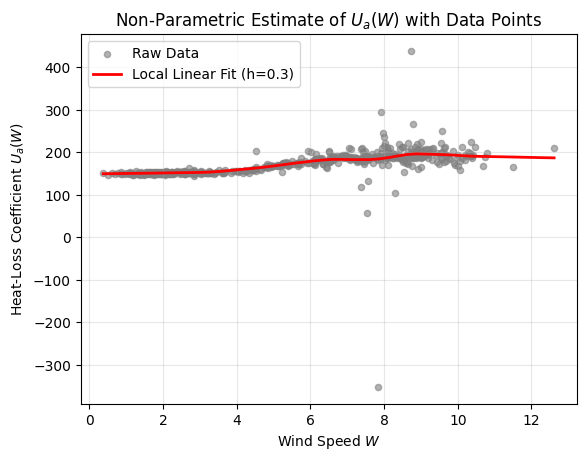

In [4]:
from scipy.interpolate import interp1d
interp_func = interp1d(x_w, ua_fit, kind='linear', fill_value='extrapolate')
ua_pred = interp_func(df['W'])
residuals = Ua - ua_pred

# plt.figure(figsize=(8, 6))
plt.scatter(df['W'], Ua, alpha=0.6, color='gray', s=20, label='Raw Data')
plt.plot(x_w, ua_fit, 'r-', linewidth=2, label='Local Linear Fit (h=0.3)')
plt.xlabel('Wind Speed $W$')
plt.ylabel('Heat-Loss Coefficient $U_a(W)$')
plt.title('Non-Parametric Estimate of $U_a(W)$ with Data Points')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

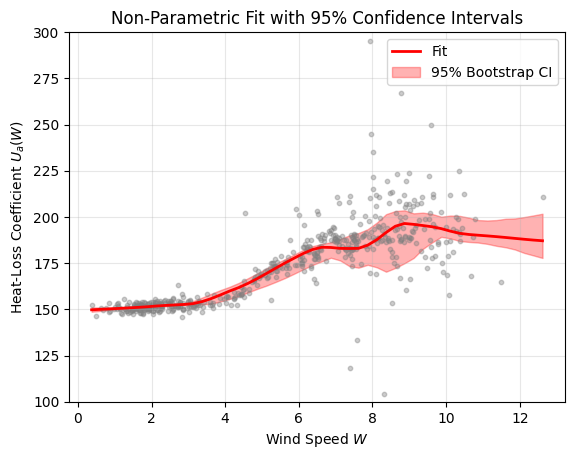

In [35]:
from sklearn.utils import resample

n_boot = 100
ua_boots = np.zeros((len(x_w), n_boot))
for b in range(n_boot):
    boot_idx = resample(range(len(df)), replace=True)
    boot_data = data4[boot_idx]
    _, ua_boot = regsmooth1d(boot_data, 50, 1, 0.3)
    ua_boots[:, b] = ua_boot
ua_lower = np.percentile(ua_boots, 2.5, axis=1)
ua_upper = np.percentile(ua_boots, 97.5, axis=1)

plt.plot(x_w, ua_fit, 'r-', linewidth=2, label='Fit')
plt.fill_between(x_w, ua_lower, ua_upper, alpha=0.3, color='red', label='95% Bootstrap CI')
plt.scatter(df['W'], Ua, alpha=0.4, color='gray', s=10)
plt.xlabel('Wind Speed $W$')
plt.ylabel('Heat-Loss Coefficient $U_a(W)$')
plt.title('Non-Parametric Fit with 95% Confidence Intervals')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(100, 300)
plt.savefig('plots/non_parametric_fit_with_95_confidence_intervals.png')
plt.show()

In [ ]:
def optimal_bandwidth_cv(data, h_candidates=None):
    """Find optimal bandwidth using leave-one-out cross-validation"""
    if h_candidates is None:
        h_candidates = np.arange(0.1, 1.0, 0.1)
    
    cv_errors = []
    for h in h_candidates:
        mse = 0
        for i in range(len(data)):
            # Leave out point i
            train_data = np.delete(data, i, axis=0)
            x_val, y_val = regsmooth1d(train_data, 50, 1, h)
            
            # Predict for left-out point
            from scipy.interpolate import interp1d
            f = interp1d(x_val, y_val, kind='linear', fill_value='extrapolate')
            pred = f(data[i, 0])
            mse += (data[i, 1] - pred)**2
        
        cv_errors.append(mse / len(data))
    
    optimal_h = h_candidates[np.argmin(cv_errors)]
    return optimal_h, cv_errors

# Find optimal bandwidth
Ua = df['Phi'] / (df['Ti'] - df['Te'])
data4 = np.column_stack((df['W'], Ua))

h_candidates = np.arange(0.1, 0.8, 0.05)
optimal_h, cv_errors = optimal_bandwidth_cv(data4, h_candidates)

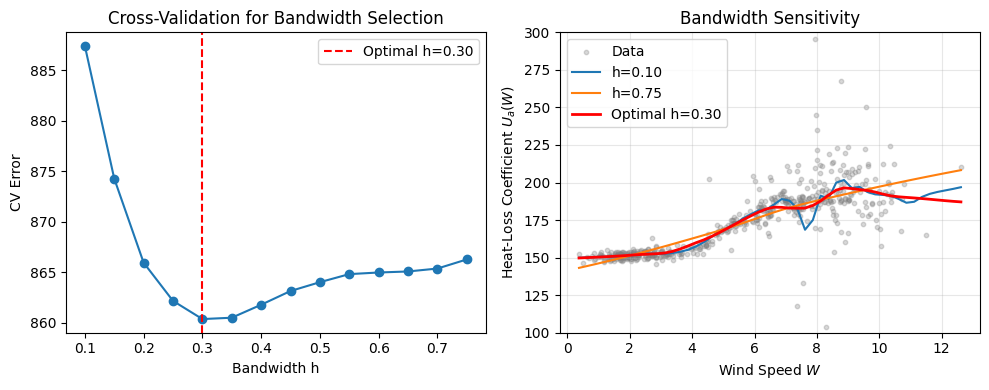

In [29]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.plot(h_candidates, cv_errors, 'o-')
plt.axvline(optimal_h, color='red', linestyle='--', label=f'Optimal h={optimal_h:.2f}')
plt.xlabel('Bandwidth h')
plt.ylabel('CV Error')
plt.title('Cross-Validation for Bandwidth Selection')
plt.legend()

plt.subplot(1,2,2)
# Plot sensitivity for first and last h values from grid search
h_first = h_candidates[0]
h_last = h_candidates[-1]
x_w_first, ua_fit_first = regsmooth1d(data4, 50, 1, h_first)
x_w_last, ua_fit_last = regsmooth1d(data4, 50, 1, h_last)
x_w_opt, ua_fit_opt = regsmooth1d(data4, 50, 1, optimal_h)

plt.scatter(df['W'], Ua, alpha=0.3, color='gray', s=10, label='Data')
plt.plot(x_w_first, ua_fit_first, label=f'h={h_first:.2f}')
plt.plot(x_w_last, ua_fit_last, label=f'h={h_last:.2f}')
plt.plot(x_w_opt, ua_fit_opt, 'r-', linewidth=2, label=f'Optimal h={optimal_h:.2f}')
plt.xlabel('Wind Speed $W$')
plt.ylabel('Heat-Loss Coefficient $U_a(W)$')
plt.title('Bandwidth Sensitivity')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(100, 300)

plt.tight_layout()
plt.savefig('plots/optimal_bandwidth_cv.png')
plt.show()

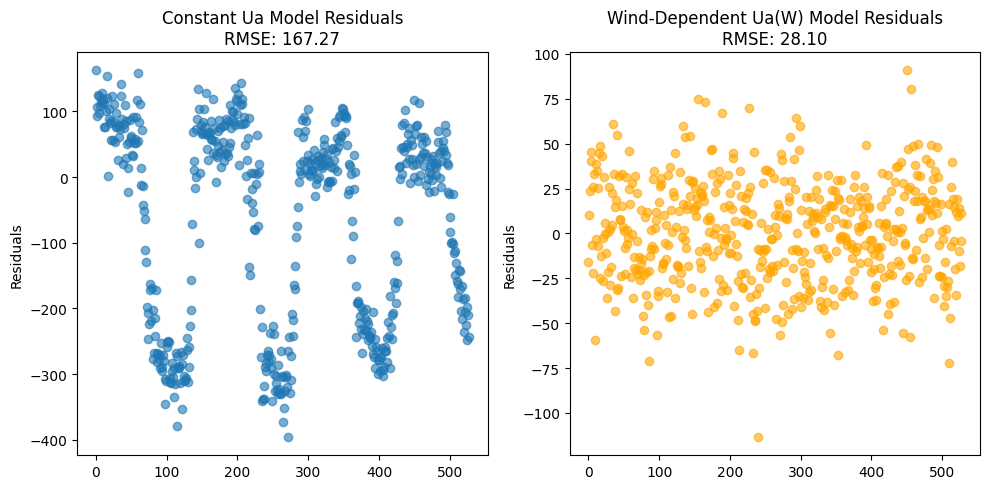

In [30]:
# Constant Ua model
Ua_constant = np.mean(Ua)
residuals_constant = df['Phi'] - Ua_constant * (df['Ti'] - df['Te'])

# Wind-dependent Ua model 
from scipy.interpolate import interp1d
ua_interp = interp1d(x_w, ua_fit, kind='linear', fill_value='extrapolate')
Ua_fitted = ua_interp(df['W'])
residuals_wind = df['Phi'] - Ua_fitted * (df['Ti'] - df['Te'])

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.scatter(range(len(residuals_constant)), residuals_constant, alpha=0.6)
ax1.set_title(f'Constant Ua Model Residuals\nRMSE: {np.sqrt(np.mean(residuals_constant**2)):.2f}')
ax1.set_ylabel('Residuals')

ax2.scatter(range(len(residuals_wind)), residuals_wind, alpha=0.6, color='orange')
ax2.set_title(f'Wind-Dependent Ua(W) Model Residuals\nRMSE: {np.sqrt(np.mean(residuals_wind**2)):.2f}')
ax2.set_ylabel('Residuals')

plt.tight_layout()
plt.savefig('plots/constant_vs_wind_dependent_Ua.png')
plt.show()

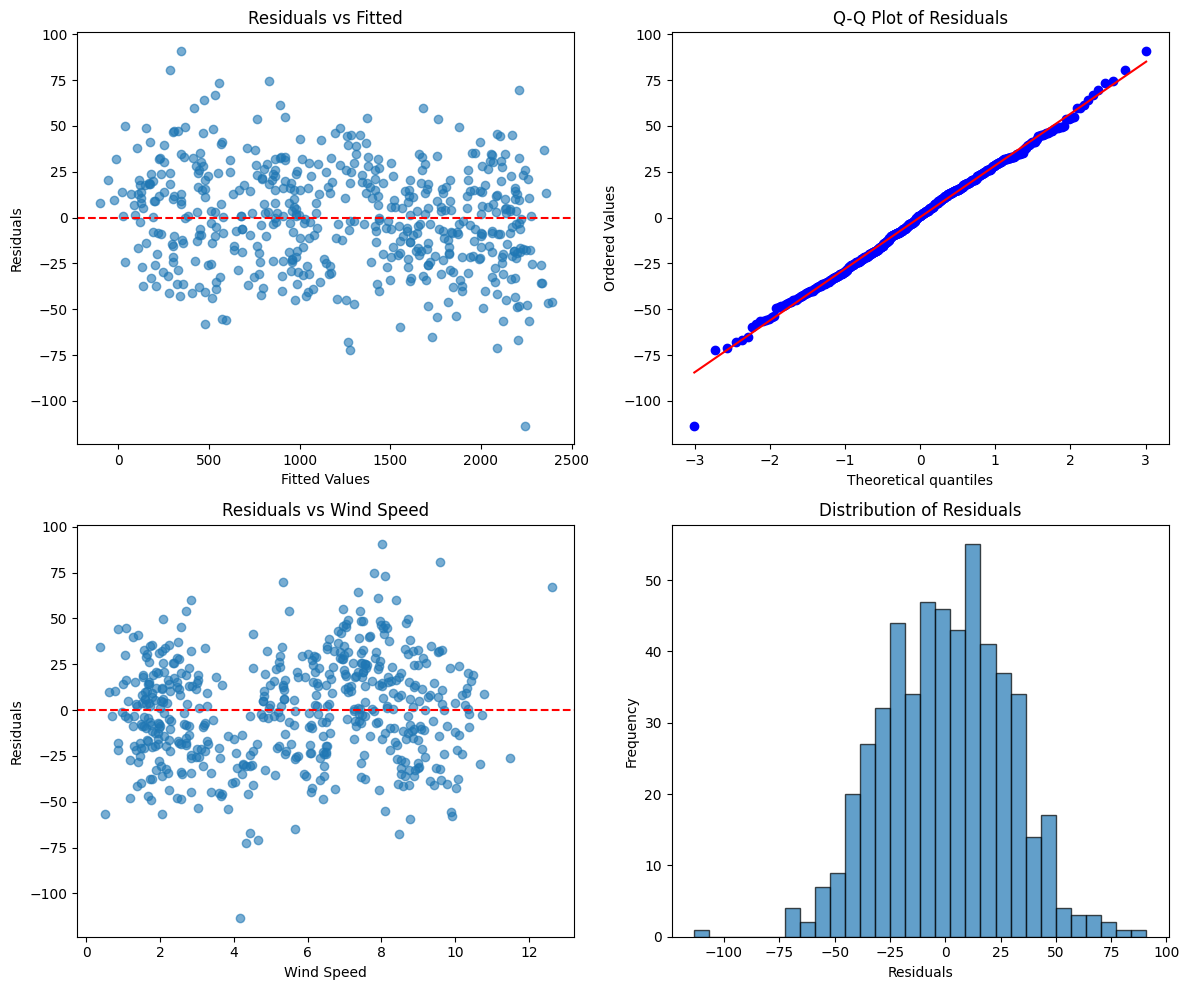

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Residuals vs fitted
axes[0,0].scatter(Ua_fitted * (df['Ti'] - df['Te']), residuals_wind, alpha=0.6)
axes[0,0].axhline(0, color='red', linestyle='--')
axes[0,0].set_xlabel('Fitted Values')
axes[0,0].set_ylabel('Residuals')
axes[0,0].set_title('Residuals vs Fitted')

# QQ plot of residuals
from scipy import stats
stats.probplot(residuals_wind, dist="norm", plot=axes[0,1])
axes[0,1].set_title('Q-Q Plot of Residuals')

# Residuals vs wind speed
axes[1,0].scatter(df['W'], residuals_wind, alpha=0.6)
axes[1,0].axhline(0, color='red', linestyle='--')
axes[1,0].set_xlabel('Wind Speed')
axes[1,0].set_ylabel('Residuals')
axes[1,0].set_title('Residuals vs Wind Speed')

# Histogram of residuals
axes[1,1].hist(residuals_wind, bins=30, edgecolor='black', alpha=0.7)
axes[1,1].set_xlabel('Residuals')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Distribution of Residuals')

plt.tight_layout()
plt.savefig('plots/residuals_vs_fitted_wind_dependent_Ua.png')
plt.show()